In [82]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [83]:
create_experiment_snapshots([25, 50, 75, 100])

In [84]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = 100
scheme = 'mtd_ai'
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
features = ["overall_asr_avg", "risk"]
model = "main_network_final_overall_asr_avg#risk"

In [85]:
# Define the columns of the DataFrame
columns = features
security_metrics = pd.DataFrame(columns=features)


In [86]:
for _ in range(5):
    evaluation = execute_ai_model(model=model, features=features, start_time=start_time, finish_time=finish_time, mtd_interval=mtd_interval, scheme=scheme, total_nodes=total_nodes, new_network=new_network)
    security_metrics_trial = evaluation.security_metrics_record.get_record().drop('times', axis=1).iloc[-1]
    security_metrics = pd.concat([security_metrics, pd.DataFrame([security_metrics_trial])], ignore_index=True)

normalization_values = {
    'host_compromise_ratio': 3,
    'exposed_endpoints': 5.0,
    'attack_path_exposure_score': 0.5,
    'overall_asr_ratio': 0.5,
    'roa': 20.0,
    'shortest_path_vulnerability': 0.1,
    'risk': 5.0,
    'mtd_frequency': 0.015,
    'overall_mtcc_avg': 2000.0,
    'time_since_last_mtd': 100.0
}
# Normalize each column using the normalization values
for column, norm_value in normalization_values.items():
    if column in security_metrics.columns:
        security_metrics[column] = security_metrics[column] / norm_value


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [87]:
# Calculate median and standard deviation for each column
results = {
    'Median': security_metrics.median(),
    'Standard Deviation': security_metrics.std()
}

# Convert to DataFrame for better readability
results_security_metrics = pd.DataFrame(results).dropna()

print(results_security_metrics)

                         Median Standard Deviation
host_compromise_ratio  0.063462           0.014566
exposed_endpoints       0.42801           0.470702
mtd_frequency          0.508851            0.04313
overall_mtcc_avg       0.919031           0.105242
time_since_last_mtd    0.800597           0.360857


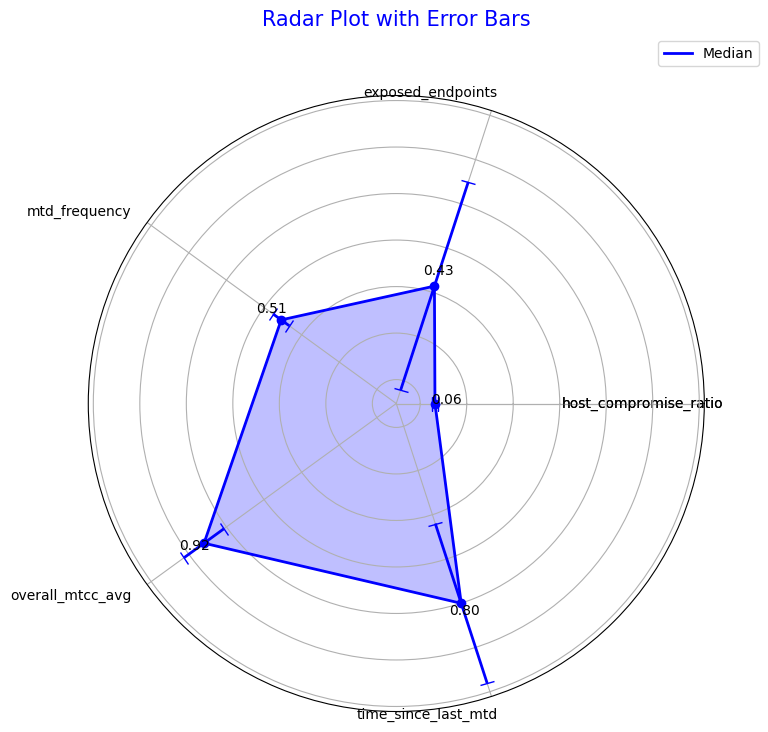

In [88]:

# Data from results_security_metrics DataFrame
metrics_values = results_security_metrics['Median'].tolist()
std_dev_values = results_security_metrics['Standard Deviation'].tolist()
labels = results_security_metrics.index.tolist()

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Repeat the first value to close the circle
angles += angles[:1]
metrics_values += metrics_values[:1]
std_dev_values += std_dev_values[:1]
labels += labels[:1]  # Close the circle by repeating the first label

# Create radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot data
ax.fill(angles, metrics_values, color='blue', alpha=0.25)
ax.plot(angles, metrics_values, color='blue', linewidth=2, label='Median')

# Add error bars
for i in range(num_vars):
    angle = angles[i]
    value = metrics_values[i]
    error = std_dev_values[i]
    ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

# Add score labels
for i in range(num_vars):
    angle = angles[i]
    value = metrics_values[i]
    # Position the text slightly away from the plotted point
    ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')


# Labels
ax.set_yticklabels([])
ax.set_xticks(angles)  # Set ticks without the last angle
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.title('Radar Plot with Error Bars', size=15, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()
